In [20]:
%load_ext autoreload
%autoreload 2
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [334]:
from proj1_helpers import *
DATA_TRAIN_PATH = '/Users/ines/Documents/SV/SV-MA3/ML_course/projects/project1/data/train.csv' 
y_pre, tX_pre, ids = load_csv_data(DATA_TRAIN_PATH)

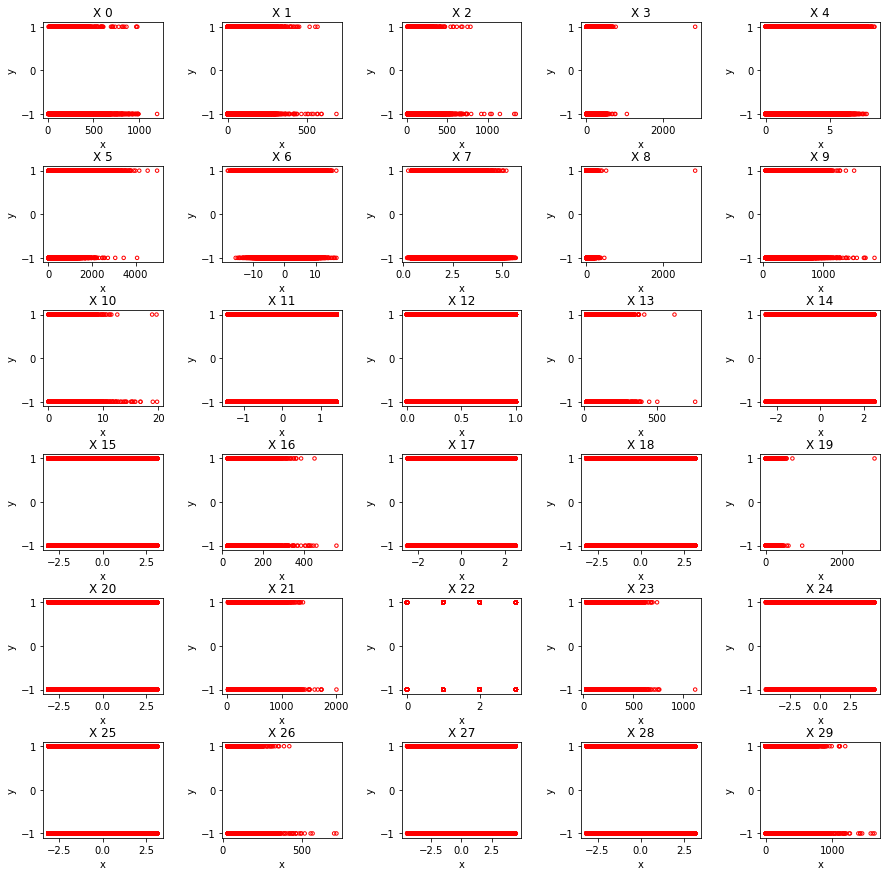

In [331]:
# Exploring data 
# define the structure of the figure
num_row = 6
num_col = 5
f, axs = plt.subplots(num_row, num_col,figsize=(15,15))

for i in range(tX_pre.shape[1]):
    ax = axs[i // num_col][i % num_col]
    ax.scatter(tX[:,i], y, color='b', s=12, facecolors='none', edgecolors='r')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("X " + str(i))

plt.subplots_adjust(wspace = .5, hspace = .5)


In [345]:
print(tX_pre[tX_pre[:,22]==0])

[0. 0. 0. ... 0. 0. 0.]


NameError: name 'y' is not defined

In [280]:
#############################
#### Preprocessing
#############################

from implementations import *
print("Before pre-processing")
print("tX shape :", tX_pre.shape, "y shape :", y_pre.shape, ids.shape)
print("tX max", np.max(tX_pre), "tX min", np.min(tX_pre), "tX mean", 
      np.mean(tX_pre), "tX std", np.std(tX_pre))

tX_post = remove_undefined_variable(tX_pre)
tX_post, y_post = remove_aberrant_features(tX_post, y_pre)
tX_post, _ , _ = standardize(tX_post)

print("After pre processing")
print("tX shape :", tX_post.shape)
print("tX max", np.max(tX_post, axis = 0),"tX min", np.min(tX_post, axis = 0), "tX mean", 
      np.mean(tX_post,axis=0), "tX std", np.std(tX_post, axis=0))




Before pre-processing
tX shape : (250000, 30) y shape : (250000,) (250000,)
tX max 4974.979 tX min -999.0 tX mean -175.14058052786658 tX std 433.5002560560245
After pre processing
tX shape : (250000, 29)
tX max [ 20.28761496  18.13095307  31.06079422  43.6270341    6.49902449
  21.48719972   9.06966802   4.22896891 126.43222168  14.64082662
  21.70533339   1.29216437   2.52241378  32.37994915   2.06574596
   1.7339506   23.27730008   1.99410918   1.70562811  85.14763615
   1.73936983  14.18331558  22.03619106   3.25614813   2.2443359
  38.5247796    4.12250083   3.21186412  15.91961425] tX min [-2.13867247 -1.39312709 -1.83334636 -0.9095194  -2.56128122 -1.67195032
 -8.93118824 -2.76545335 -0.84932209 -0.97080817 -1.64619571 -1.07717342
 -2.13397589 -0.83470414 -2.04931693 -1.72495538 -0.93633905 -1.96484789
 -1.75356687 -1.26489454 -1.7282021  -1.55035839 -1.16637154 -3.25141162
 -2.22740716 -1.60648292 -4.10085465 -3.20863081 -0.74543941] tX mean [-2.11286988e-16  4.19362323e-17 -3.4

## Do your thing crazy machine learning thing here :) ...

In [15]:
#############################
#### Innocent test
#############################

import datetime
from implementations import *

initial_w = np.zeros(tX.shape[1])
max_iters = 500
gamma = 0.03
ratio = 0.5
batch_size = 100

x_tr, x_te, y_tr, y_te = split_data(tX, y, ratio, seed=1)
print(x_tr.shape,x_te.shape,y_tr.shape,y_te.shape)
start_time_ls = datetime.datetime.now()
w_ls, mse_ls = least_squares(y_tr, x_tr)
end_time_ls = datetime.datetime.now()
execution_time_ls = (end_time_ls - start_time_ls).total_seconds()

start_time_GD = datetime.datetime.now()
w_GD, loss_GD = least_squares_GD(y, tX, initial_w, max_iters, gamma)
end_time_GD = datetime.datetime.now()
execution_time_GD = (end_time_GD - start_time_GD).total_seconds()

start_time_SGD = datetime.datetime.now()
w_SGD, loss_SGD = least_squares_SGD(y, tX, initial_w, max_iters, batch_size, gamma)
end_time_SGD = datetime.datetime.now()
execution_time_SGD = (end_time_SGD - start_time_SGD).total_seconds()
print('LS : accuracy :', compute_accuracy(x_te, y_te, w_ls), 'execution time : ', execution_time_ls)
print('GD : accuracy :', compute_accuracy(x_te, y_te, w_GD), 'execution time : ', execution_time_GD)
print('SGD : accuracy :', compute_accuracy(x_te, y_te ,w_SGD), 'execution time : ', execution_time_SGD)

#weights = w_ls
# (125000, 30) (125000, 30) (125000,) (125000,)
# LS : accuracy : 71.76559999999999 execution time :  0.006621
# GD : accuracy : 71.5784 execution time :  2.740375
# SGD : accuracy : 71.4608 execution time :  15.259046

# LS : accuracy : 71.7992 execution time :  0.007241
# GD : accuracy : 71.8664 execution time :  2.694537
# SGD : accuracy : 71.6488 execution time :  0.469522

(125000, 30) (125000, 30) (125000,) (125000,)
LS : accuracy : 71.7992 execution time :  0.006519
GD : accuracy : 71.8664 execution time :  2.726243
SGD : accuracy : 71.6 execution time :  0.137342


In [ ]:
#############################
#### Choose gamma, GD 
#############################
gammas = np.logspace(-4, 0, 30)[:26]
initial_w = np.zeros(tX.shape[1])
max_iters = 200
rmse = []
accuracy = []
for gamma in gammas:
    start_time_GD = datetime.datetime.now()
    w_GD, loss_GD = least_squares_GD(y, tX, initial_w, max_iters, gamma)
    rmse.append(np.sqrt(2 * loss_GD))
    accuracy.append( compute_accuracy(tX, y, w_GD))
    print(gamma, np.sqrt(2 * loss_GD))
    end_time_GD = datetime.datetime.now()
    execution_time_GD = (end_time_GD - start_time_GD).total_seconds()

plt.subplot(2, 1, 1)
plt.plot(gammas, rmse)
plt.xscale('log')
plt.xlabel('gamma')
plt.ylabel('rmse')
plt.subplot(2, 1, 2)
plt.plot(gammas, accuracy)
plt.xscale('log')
plt.xlabel('gamma')
plt.ylabel('accuracy')


In [172]:
np.logspace(-4, 0, 30)

array([1.00000000e-04, 1.37382380e-04, 1.88739182e-04, 2.59294380e-04,
       3.56224789e-04, 4.89390092e-04, 6.72335754e-04, 9.23670857e-04,
       1.26896100e-03, 1.74332882e-03, 2.39502662e-03, 3.29034456e-03,
       4.52035366e-03, 6.21016942e-03, 8.53167852e-03, 1.17210230e-02,
       1.61026203e-02, 2.21221629e-02, 3.03919538e-02, 4.17531894e-02,
       5.73615251e-02, 7.88046282e-02, 1.08263673e-01, 1.48735211e-01,
       2.04335972e-01, 2.80721620e-01, 3.85662042e-01, 5.29831691e-01,
       7.27895384e-01, 1.00000000e+00])

In [579]:
#############################
#### With CV 
#############################

from implementations import *

def best_degree_selection(x, y, degrees, k_fold, model, seed = 1):
    
    # Split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    print("Method = ", model["model"])
    
    if model["model"] != 'LS':
        if model["model"] != 'ridge':
            list_param = model["param"][0] # gammas or lambdas
        else :
            list_param = model["param"]
        # Store all the RMSEs 
        rmses_list = np.empty([degrees.size, list_param.size])
        accuracy_list = np.empty([degrees.size, list_param.size])
   
    else:
        
        rmses_list = np.empty(degrees.size)
        accuracy_list = np.empty(degrees.size)
    
    # Vary degree
    for i, degree in enumerate(degrees):
        
        print("Degree = ", degree)
        print("Progress : ", i/len(degrees)*100 , " % ")
        
        if model["model"] != 'LS' and model["model"] != 'ridge':
                
            model["initial_w"] = np.zeros(int(x.shape[1] * degree + 1))
            
        if model["model"] != 'LR':
            
            model["initial_w"] = np.ones(int(x.shape[1] * degree + 1))/1000
            
        #####
        # Not LS
        #####
        
        if model["model"] != 'LS':

            for j, p in enumerate(list_param):

                rmse_te_tmp = np.empty(k_fold)
                accuracy_tmp = np.empty(k_fold)
                
                if model["model"] != 'ridge':
                    model["param"][0] = p
                else :
                    model["param"] = p

                for k in range(k_fold):
                    _, rmse_te, _, accuracy = cross_validation(y, x, k_indices, k, model, degree)
                    rmse_te_tmp[k] = rmse_te
                    accuracy_tmp[k] = accuracy

                rmses_list[i,j] = np.mean(rmse_te_tmp) 
                accuracy_list[i,j] = np.mean(accuracy_tmp)
       
        #####
        # LS
        #####
        
        else : 
            
            rmse_te_tmp = np.empty(k_fold)
            accuracy_tmp = np.empty(k_fold)
            
            for k in range(k_fold):
                    _, rmse_te, _, accuracy = cross_validation(y, x, k_indices, k, model, degree)
                    rmse_te_tmp[k] = rmse_te
                    accuracy_tmp[k] = accuracy

            rmses_list[i] = np.mean(rmse_te_tmp) 
            accuracy_list[i] = np.mean(accuracy_tmp)
    
    print("The method used is : ", model["model"])
    
    rmses_list = np.squeeze(rmses_list)
    accuracy_list = np.squeeze(accuracy_list)
    
    if model["model"] == 'LS':
        idx_best_degree = np.squeeze(np.argwhere(rmses_list == np.min(rmses_list)))
        print("The best degree is", degrees[idx_best_degree],
              " with RMSE = ", rmses_list[idx_best_degree],
              "and accuracy = ", accuracy_list[idx_best_degree])
    else:    
        idx_best_degree = np.squeeze(np.argwhere(rmses_list == np.min(rmses_list)))
        print("The best degree is", degrees[idx_best_degree[0]],
              " best parameter is", list_param[idx_best_degree[1]],
              " with RMSE = ", rmses_list[idx_best_degree[0],idx_best_degree[1]],
              "and accuracy = ", accuracy_list[idx_best_degree[0],idx_best_degree[1]])
        
            
    return rmses_list, accuracy_list

In [580]:
#########
# GD
#########
gammas = np.logspace(-4, -2, 3)
degrees = np.linspace(1, 2, 2)
max_iters = 200
k_fold = 5

parameters_GD = {
  "model": "GD",
  "param": [gammas, max_iters],
}


rmses_GD, accuracy_GD = best_degree_selection(tX_post, y_post, degrees, k_fold, parameters_GD, seed = 1)

Method =  GD
Degree =  1.0
Progress :  0.0  % 
Degree =  2.0
Progress :  50.0  % 
The method used is :  GD
The best degree is 1.0  best parameter is 0.01  with RMSE =  0.840886634203776 and accuracy =  73.00720000000001


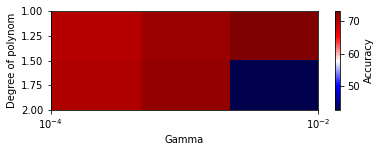

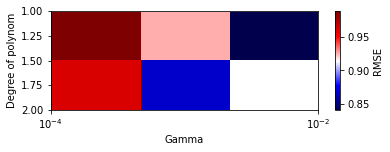

[[69.7256 71.2332 73.0072]
 [70.1336 71.7616 42.7132]]
[[0.98877173 0.9268123  0.84088663]
 [0.96247469 0.8671913         inf]]
0.840886634203776


In [576]:
plt.subplot(211)
plt.imshow(accuracy_GD, extent=[gammas[0],gammas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Gamma')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'Accuracy')
plt.show()

plt.subplot(212)
plt.imshow(rmses_GD, extent=[gammas[0],gammas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Gamma')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'RMSE')
plt.show()

print(accuracy_GD)
print(rmses_GD)
idx = np.argwhere(rmses_GD == np.min(rmses_GD))
idx = np.squeeze(idx)
print(rmses_GD[idx[0],idx[1]])

# accuracy of 74.44 with gamma = 0.2782559402207124
# D = 1
#  l = 0.01 => A = 73%, RMSE = 0.84
# D = 2
#  l = 0.001 => A = 71.7%, RMSE = 0.8673

# [[70.696  71.244  73.0068]
#  [69.424  71.728  42.712 ]]
# [[0.98919378 0.92666649 0.84090761]
#  [0.96245385 0.86734436        inf]]


In [586]:
gammas = np.logspace(-4, -2, 3)
degrees = np.linspace(1, 2, 2)
max_iters = 1000
k_fold = 5
batch_size = 1

parameters_SGD = {
  "model": "SGD",
  "param": [gammas, max_iters, batch_size],
}

rmses_SGD, accuracy_SGD = best_degree_selection(tX_post, y_post, degrees, k_fold, parameters_SGD, seed = 1)

Method =  SGD
Degree =  1.0
Progress :  0.0  % 
Degree =  2.0
Progress :  50.0  % 
The method used is :  SGD
The best degree is 1.0  best parameter is 0.001  with RMSE =  0.8604985876547021 and accuracy =  72.696


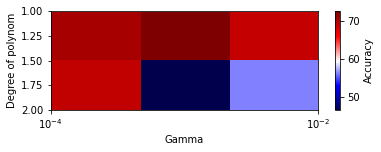

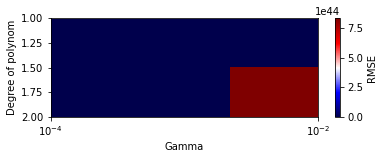

[[70.5876 72.696  69.0284]
 [69.2952 46.4408 56.3396]]
[[9.56247510e-01 8.60498588e-01 9.51475047e-01]
 [1.14586226e+00 4.50354251e+03 8.36425077e+44]]
0.8604985876547021


In [587]:
plt.subplot(211)
plt.imshow(accuracy_SGD, extent=[gammas[0],gammas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Gamma')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'Accuracy')
plt.show()

plt.subplot(212)
plt.imshow(rmses_SGD, extent=[gammas[0],gammas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Gamma')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'RMSE')
plt.show()

print(accuracy_SGD)
print(rmses_SGD)
idx = np.argwhere(rmses_SGD == np.min(rmses_SGD))
idx = np.squeeze(idx)
print(rmses_SGD[idx[0],idx[1]])

# [[69.3452 70.5404 68.7576]
#  [68.4972 64.2316 51.4024]]
# [[9.88713702e-01 9.30045726e-01 9.39897353e-01]
#  [9.82841886e-01 4.04586806e+00 2.66499874e+08]]

In [349]:
#########
# LS
#########
degrees = np.linspace(1, 20, 20)
k_fold = 5

parameters_LS = {
  "model": "LS",
}

rmses_LS, accuracy_LS = best_degree_selection(tX_post, y_post, degrees, k_fold, parameters_LS, seed = 1)

Progress :  0.0  % 
Progress :  5.0  % 
Progress :  10.0  % 
Progress :  15.0  % 
Progress :  20.0  % 
Progress :  25.0  % 
Progress :  30.0  % 
Progress :  35.0  % 
Progress :  40.0  % 
Progress :  45.0  % 
Progress :  50.0  % 
Progress :  55.00000000000001  % 
Progress :  60.0  % 
Progress :  65.0  % 
Progress :  70.0  % 
Progress :  75.0  % 
Progress :  80.0  % 
Progress :  85.0  % 
Progress :  90.0  % 
Progress :  95.0  % 


The best degree is :
[[7.]]
[74.4328 77.4224 78.4956 79.208  79.5864 79.8376 80.3888 81.076  81.4972
 81.2768 81.6904 81.8084 81.8604 76.1364 72.708  71.4216 68.846  56.6036
 56.9248 51.9396]
[8.25257849e-01 8.91146409e-01 3.54288013e+00 7.80180019e+00
 8.91474165e+02 1.21157402e+04 5.83553358e+05 8.61621693e+06
 3.85572183e+08 7.45393321e+09 2.28937484e+11 3.04213246e+12
 6.11037702e+14 1.58729091e+15 6.43580025e+17 2.19339260e+19
 3.45406315e+18 2.98800001e+21 2.06860330e+22 1.82544719e+23]


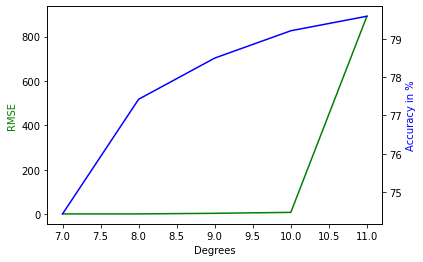

In [557]:
print("The best degree is :", )

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
stop = 5
idx = np.argwhere(rmses_LS == np.min(rmses_LS))
print(degrees[idx])
ax1.plot(degrees[:stop], rmses_LS[:stop], 'g-')
ax2.plot(degrees[:stop], accuracy_LS[:stop], 'b-')

ax1.set_xlabel('Degrees')
ax1.set_ylabel('RMSE', color='g')
ax2.set_ylabel('Accuracy in %', color='b')

print(accuracy_LS)
print(rmses_LS)

# Without preprocessing :
#    A = 74.43, RMSE = 0.83
# best accuracy 81.86, degree 13


81.634


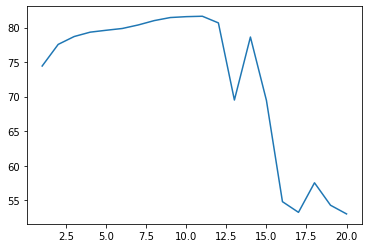

In [393]:
x_tr, x_te, y_tr, y_te = split_data(tX_post, y_post, 0.8, seed=1)
degrees = np.linspace(1, 20, 20)

w_list = np.empty(degrees.size)
mse_list = np.empty(degrees.size)
accuracies = np.empty(degrees.size)

parameters_LS = {
  "model": "LS",
}

for d in degrees:
    idx = int(d-1)
    
    # form data with polynomial degree:
    x_tr_p = build_poly(x_tr, d)
    x_te_p = build_poly(x_te, d)
    
    w_list, mse_list = least_squares(y_tr, x_tr_p)
    accuracies[idx] = compute_accuracy(x_te_p, y_te, w_list, parameters_LS)

plt.plot(degrees, accuracies)


# lowest RMSE for degree = 11, accuracy 81.634  

In [506]:
#########
# Ridge
#########

degrees = np.linspace(1, 3, 3)
lambdas = np.logspace(-6, -2, 5)
k_fold = 5

parameters_ridge = {
  "model": "ridge",
  "param": lambdas,
}

rmses_ridge, accuracy_ridge = best_degree_selection(tX_post, y_post, degrees, k_fold, parameters_ridge, seed = 1)

Progress :  0.0  % 
Progress :  33.33333333333333  % 
Progress :  66.66666666666666  % 


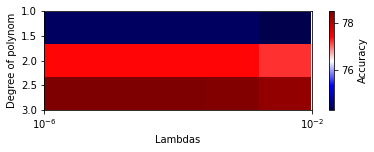

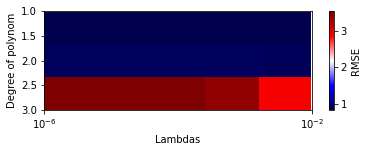

[[74.4352 74.4348 74.4364 74.428  74.3104]
 [77.4288 77.4276 77.4256 77.4184 77.2464]
 [78.4944 78.4948 78.4876 78.4556 78.3288]]
[[0.82525299 0.82525298 0.82525294 0.82525853 0.82575158]
 [0.89112642 0.89111792 0.89103399 0.89028859 0.88736233]
 [3.54318646 3.54227264 3.53319439 3.44793722 2.90259059]]


In [508]:
plt.subplot(211)
plt.imshow(accuracy_ridge, extent=[lambdas[0],lambdas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Lambdas')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'Accuracy')
plt.show()

plt.subplot(212)
plt.imshow(rmses_ridge, extent=[lambdas[0],lambdas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Lambdas')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'RMSE')
plt.show()

print(accuracy_2d_ridge)
print(rmse_2d_ridge)

# Best accuracy : 81.8908, with lambda = 0.001, degree = 13
# Or also good : 81.72, l = 0.001, d = 11

# with lambdas bigger than 10-6, the RMSE is bigger than 10^7, after degree 9

# D = 1, L = 10-4, RMSE = 0.82525294, Accuracy = 74.44%

# [[74.4352 74.4348 74.4364 74.428  74.3104]
#  [77.4288 77.4276 77.4256 77.4184 77.2464]
#  [78.4944 78.4948 78.4876 78.4556 78.3288]]
# [[0.82525299 0.82525298 0.82525294 0.82525853 0.82575158]
#  [0.89112642 0.89111792 0.89103399 0.89028859 0.88736233]
#  [3.54318646 3.54227264 3.53319439 3.44793722 2.90259059]]


In [364]:
#########
# LR
#########

degrees = np.linspace(1, 2, 2)
lambdas = np.logspace(-6, -4, 2)
k_fold = 5
max_iters = 1000

parameters_LR = {
      "model": "LR",
      "param": [lambdas, max_iters],
}

rmses_LR, accuracy_LR = best_degree_selection(tX_post, y_post, degrees, k_fold, parameters_LR, seed = 1)

Progress :  0.0  % 
Progress :  50.0  % 


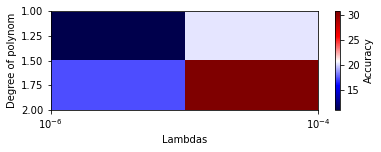

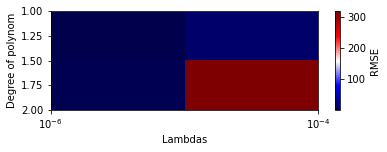

[[11.0844 20.4916]
 [17.506  30.852 ]]
[[  1.39563657  15.32056015]
 [  4.43297277 318.23925906]]


In [365]:
plt.subplot(211)
plt.imshow(accuracy_LR, extent=[lambdas[0],lambdas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Lambdas')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'Accuracy')
plt.show()

plt.subplot(212)
plt.imshow(rmses_LR, extent=[lambdas[0],lambdas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Lambdas')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'RMSE')
plt.show()

print(accuracy_LR)
print(rmses_LR)

In [255]:
################
# CV log reg
###############


def CV_LR(degrees, gammas, max_iters, k_fold, seed = 1):
    
    # Split data in k fold
    k_indices = build_k_indices(y_pre, k_fold, seed)

    # For each degree, store :
    best_param = []
#     best_rmses = []
    best_accuracy = []
    
    parameters_LR = {
      "model": "LR",
      "param": [0, max_iters],
    }

    # Vary degree
    for i, degree in enumerate(degrees):

        print("Progress : ", i/len(degrees)*100 , " % ")
       
        parameters_LR["initial_w"] = np.ones(int(tX_post.shape[1] * degree + 1))
        
        # Contains the rmse/accuracy for 1 degree and all gammas
#         rmse_gamma = []
        accuracy_gamma = []
        
        for gamma in gammas:
            
            parameters_LR["param"][0] = gamma
            
            # Contains rmse or accuracy for each k_fold
#             rmse_te_tmp = []
            accuracy_tmp = []
            
            for k in range(k_fold):
                _, _, _, accuracy = cross_validation(y_pre, tX_post, k_indices, k, parameters_LR, degree)
#                 rmse_te_tmp.append(rmse_te)
                accuracy_tmp.append(accuracy)

#             rmse_gamma.append(np.mean(rmse_te_tmp))
            accuracy_gamma.append(np.mean(accuracy_tmp))
        
#         idx_best_gamma =  np.argmin(rmse_gamma)
        idx_best_gamma =  np.argmax(accuracy_gamma)
        best_param.append(gammas[idx_best_gamma])
#         best_rmses.append(rmse_gamma[idx_best_gamma])
        best_accuracy.append(accuracy_gamma[idx_best_gamma])


#     idx_best_degree =  np.argmin(best_rmses)
    idx_best_degree =  np.argmax(best_accuracy)



    return idx_best_degree, best_param, best_accuracy#, best_rmses




In [260]:
from implementations import * 
from proj1_helpers import *

DATA_TRAIN_PATH = '/Users/ines/Documents/SV/SV-MA3/ML_course/projects/project1/data/train.csv' 
y_pre, tX_pre, ids = load_csv_data(DATA_TRAIN_PATH)

tX_post = remove_undefined_variable(tX_pre)
tX_post, y_post = remove_aberrant_features(tX_post, y_pre)
tX_post = tX_post - np.min(tX_post)/(np.max(tX_post)- np.min(tX_post))

degrees = np.linspace(1, 2, 2)
gammas = np.logspace(-6, -5, 2)
k_fold = 5
max_iters = 200

# idx_best_degree_LR, best_param_LR, best_accuracy_LR, best_rmses_LR = CV_LR(degrees, gammas, max_iters, k_fold, seed = 1)
idx_best_degree_LR, best_param_LR, best_accuracy_LR = CV_LR(degrees, gammas, max_iters, k_fold, seed = 1)

Progress :  0.0  % 
Progress :  50.0  % 


The best degree is : 1.0
The best gamma is : 1e-06
[56.1244, 45.72760000000001]


Text(0, 0.5, 'Accuracy in %')

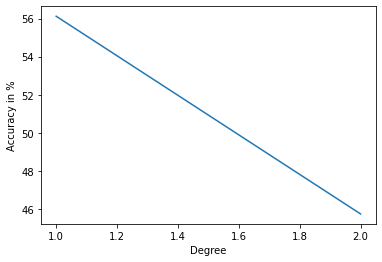

In [261]:
print("The best degree is :", degrees[idx_best_degree_LR])
print("The best gamma is :", best_param_LR[idx_best_degree_LR])
# print(best_rmses_LR)
print(best_accuracy_LR)

# fig, ax1 = plt.subplots()

# ax2 = ax1.twinx()
# stop = 10
# ax1.plot(degrees[:stop], best_rmses_LR[:stop], 'g-')
# ax2.plot(degrees[:stop], best_accuracy_LR[:stop], 'b-')

# ax1.set_xlabel('Degree')
# ax1.set_ylabel('RMSE', color='g')
# ax2.set_ylabel('Accuracy in %', color='b')

# plt.show()

plt.plot(degrees, best_accuracy_LR)
plt.xlabel('Degree')
plt.ylabel('Accuracy in %')

In [ ]:
################
# CV reg log reg
###############

degrees = np.linspace(7, 13, 7)
lambdas = np.logspace(-4, 0, 5)
gamma = 0.0001
k_fold = 5
max_iters = 200

parameters_REG_LR = {
      "model": "REG_LR",
      "param": [lambdas, max_iters, gammas],
}

rmses_ridge, accuracy_ridge =  best_degree_selection(degrees, k_fold, parameters_REG_LR, seed = 1)



In [177]:
################
# CV reg log reg
###############


def CV_REG_LR(degrees, gamma, lambdas, max_iters, k_fold, seed = 1):
    
    # Split data in k fold
    k_indices = build_k_indices(y_pre, k_fold, seed)

    # For each degree, store :
    best_param = []
#     best_rmses = []
    best_accuracy = []
    
    parameters_REG_LR = {
      "model": "REG_LR",
      "param": [0, max_iters, gamma],
    }

    # Vary degree
    for i, degree in enumerate(degrees):

        print("Progress : ", i/len(degrees)*100 , " % ")
       
        parameters_REG_LR["initial_w"] = np.ones(int(tX_post.shape[1] * degree + 1))
        
        # Contains the rmse/accuracy for 1 degree and all gammas
#         rmse_gamma = []
        accuracy_lambda = []
        
        for lambda_ in lambdas:
            
            parameters_REG_LR["param"][0] = lambda_
            
            # Contains rmse or accuracy for each k_fold
#             rmse_te_tmp = []
            accuracy_tmp = []
            
            for k in range(k_fold):
                _, _, _, accuracy = cross_validation(y_pre, tX_post, k_indices, k, parameters_REG_LR, degree)
#                 rmse_te_tmp.append(rmse_te)
                accuracy_tmp.append(accuracy)

#             rmse_gamma.append(np.mean(rmse_te_tmp))
            accuracy_lambda.append(np.mean(accuracy_tmp))
        
#         idx_best_gamma =  np.argmin(rmse_gamma)
        idx_best_lambda =  np.argmax(accuracy_lambda)
        best_param.append(lambdas[idx_best_lambda])
#         best_rmses.append(rmse_gamma[idx_best_gamma])
        best_accuracy.append(accuracy_lambda[idx_best_lambda])


#     idx_best_degree =  np.argmin(best_rmses)
    idx_best_degree =  np.argmax(best_accuracy)



    return idx_best_degree, best_param, best_accuracy#, best_rmses





In [ ]:
degrees = np.linspace(7, 13, 7)
lambdas = np.logspace(-4, 0, 5)
gamma = 0.0001
k_fold = 5
max_iters = 200

idx_best_degree_reg_LR, best_param_reg_LR, best_accuracy_reg_LR = CV_REG_LR(degrees, gamma, lambdas, max_iters, k_fold, seed = 1)

The best degree is : 7.0
The best gamma is : 0.0001
[57.404399999999995, 45.2808, 56.0492, 44.8988, 54.72760000000001, 44.4964, 53.74000000000001]


Text(0, 0.5, 'Accuracy in %')

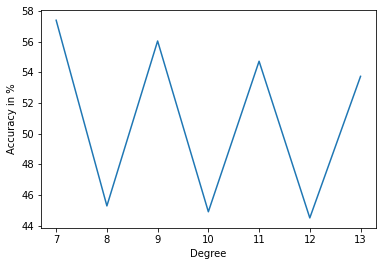

In [179]:
print("The best degree is :", degrees[idx_best_degree_reg_LR])
print("The best gamma is :", gammas[idx_best_degree_reg_LR])
print(best_accuracy_reg_LR)

plt.plot(degrees, best_accuracy_reg_LR)
plt.xlabel('Degree')
plt.ylabel('Accuracy in %')

In [472]:
from implementations import *

jet = categorizing(tX_pre)

parameters_LS = {
  "model": "LS",
}

num_row = len(jet)
num_col = 1
accuracies_all = []


for i in range(len(jet)) :
    tX_jet = clear_jet(tX_post[jet[i]])

    x_tr, x_te, y_tr, y_te = split_data(tX_jet, y_post[jet[i]], 0.8, seed=1)
    degrees = np.linspace(1, 20, 20)
    accuracies_d = []


    for d in degrees:
        idx = int(d-1)

        # form data with polynomial degree:
        x_tr_p = build_poly(x_tr, d)
        x_te_p = build_poly(x_te, d)

        w_list, mse_list = least_squares(y_tr, x_tr_p)
        accuracies_d.append(compute_accuracy(x_te_p, y_te, w_list, parameters_LS))
        
    accuracies_all.append(accuracies_d)


(99913, 18)
(77544, 22)
(50379, 29)
(22164, 29)


84.91217534904669
[[10.]]
80.40492617190019
[[13.]]
83.03890432711394
[[13.]]
83.57771260997067
[[9.]]


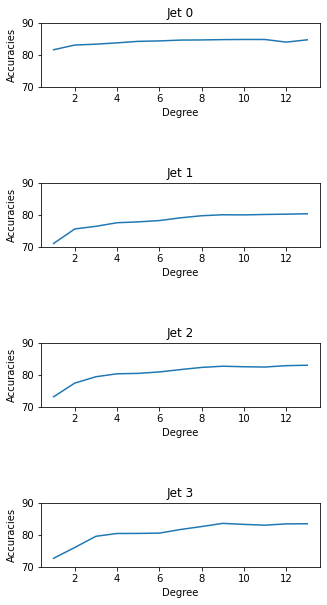

In [490]:
num_row = 4
num_col = 1
f, axs = plt.subplots(num_row, num_col,figsize=(5,10))
stop = 13
for i, acc in enumerate(accuracies_all):
    # equivalent but more general
    print(np.max(acc))
    print(degrees[np.argwhere(acc == np.max(acc))])
    ax1 = plt.subplot(num_row, 1, i+1)
    ax1.plot(degrees[:stop], acc[:stop])
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Accuracies")
    ax1.set_ylim([70,90])
    ax1.set_title("Jet " + str(i))

    plt.subplots_adjust(wspace = .5, hspace = 1.5)

In [535]:
jet = categorizing(tX_pre)

#########
# Ridge
#########

degrees = np.linspace(7, 13, 7)
lambdas = np.logspace(-6, 0, 6)
k_fold = 5


rmse_all_ridge = []
accuracy_all_ridge = []


for i in range(len(jet)):
    
    parameters_ridge = {
      "model": "ridge",
      "param": lambdas,
    }
    
    tX_jet = clear_jet(tX_post[jet[i]])
    y_jet = y_post[jet[i]]
    
    rmses_ridge, accuracy_ridge = best_degree_selection(tX_jet, y_jet, degrees, k_fold, parameters_ridge, seed = 1)
    
rmse_all_ridge.append(rmses_ridge)
accuracy_all_ridge.append(accuracy_ridge)

Progress :  0.0  % 
Progress :  14.285714285714285  % 
Progress :  28.57142857142857  % 
Progress :  42.857142857142854  % 
Progress :  57.14285714285714  % 
Progress :  71.42857142857143  % 
Progress :  85.71428571428571  % 
Progress :  0.0  % 
Progress :  14.285714285714285  % 
Progress :  28.57142857142857  % 
Progress :  42.857142857142854  % 
Progress :  57.14285714285714  % 
Progress :  71.42857142857143  % 
Progress :  85.71428571428571  % 
Progress :  0.0  % 
Progress :  14.285714285714285  % 
Progress :  28.57142857142857  % 
Progress :  42.857142857142854  % 
Progress :  57.14285714285714  % 
Progress :  71.42857142857143  % 
Progress :  85.71428571428571  % 
Progress :  0.0  % 
Progress :  14.285714285714285  % 
Progress :  28.57142857142857  % 
Progress :  42.857142857142854  % 
Progress :  57.14285714285714  % 
Progress :  71.42857142857143  % 
Progress :  85.71428571428571  % 


In [553]:
rmse_all_ridge = np.squeeze(rmse_all_ridge)


idx = np.squeeze(np.argwhere(rmse_all_ridge == np.min(rmse_all_ridge)))
print("best degree", degrees[idx[0]])
print("best lambda", lambdas[idx[1]])

print(rmse_all_ridge[idx[0],idx[1]])

print(np.squeeze(accuracy_all_ridge)[idx[0],idx[1]])


best degree 7.0
best lambda 0.003981071705534969
1.4254171448575879
81.00631768953069


## Generate predictions and save ouput in csv format for submission:

In [250]:
DATA_TEST_PATH = '/Users/ines/Documents/SV/SV-MA3/ML_course/projects/project1/data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [252]:
OUTPUT_PATH = '/Users/ines/Documents/SV/SV-MA3/ML_course/projects/project1/data/sample-submission.csv' # TODO: fill in desired name of output file for submission
# weights, _ = ridge_regression(y_post, tX_post, 0.001)
# print(tX_test.shape)
# tX_test = np.delete(tX_test, 22, 1)
# tX_test.shape
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)